In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.util import random_noise
from tensorflow.keras.layers import Layer, Conv2D, Add, ReLU, Concatenate, GlobalAveragePooling2D, Multiply, Input, Lambda,  MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from keras.models import load_model
from tensorflow.keras.saving import register_keras_serializable


In [10]:
def plot_side_by_side(x_noisy, x_original, n=10):
    """
    Visualizza n coppie di immagini affiancando l'immagine rumorosa e quella originale per immagini a colori.
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')

        # Immagine originale
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(x_original[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:

def plot_denoising_results(x_test_noisy, decoded_imgs, x_test, n=10):
    """
    Visualizza n immagini rumorose, le rispettive immagini denoised e quelle originali.
    """
    plt.figure(figsize=(20, 4))
    n = 10
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')
        # Immagine denoised
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("Denoised")
        plt.axis('off')
        # Immagine originale
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(x_test[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



In [12]:
def plot_side_by_side(x_noisy, x_original, n=10):
    """
    Visualizza n coppie di immagini affiancando l'immagine rumorosa e quella originale per immagini a colori.
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')

        # Immagine originale
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(x_original[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [13]:
# MeanShift: sottrae (o aggiunge) la media RGB
@register_keras_serializable("MeanShift")
class MeanShift(Layer):
    def __init__(self, rgb_mean, sign=-1, **kwargs):
        """
        rgb_mean: tupla con la media dei canali R, G, B.
        sign: -1 per sottrarre la media, 1 per aggiungerla.
        """
        super(MeanShift, self).__init__(**kwargs)
        self.rgb_mean = tf.constant(rgb_mean, dtype=tf.float32)
        self.sign = sign

    def call(self, x):
        # x è atteso in formato (batch, altezza, larghezza, 3)
        # Sfruttiamo Lambda per eseguire l'operazione per ogni elemento
        # Nota: non stiamo scalando per std in questo esempio
        return x + self.sign * self.rgb_mean

# BasicBlock: Conv2D seguita da attivazione ReLU
@register_keras_serializable("BasicBlock")
class BasicBlock(Layer):
    def __init__(self, out_channels, kernel_size=3, stride=1, use_bias=False, **kwargs):
        super(BasicBlock, self).__init__(**kwargs)
        self.conv = Conv2D(out_channels, kernel_size, strides=stride,
                           padding='same', use_bias=use_bias)
        self.relu = ReLU()

    def call(self, x):
        return self.relu(self.conv(x))

# ResidualBlock: due convoluzioni con skip connection(come lavora cuda con 2 thread -> 2 filtri applicati e poi si uniscono i risultati)
@register_keras_serializable("ResidualBlock")
class ResidualBlock(Layer):
    def __init__(self, out_channels, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu = ReLU()
        self.conv2 = Conv2D(out_channels, 3, strides=1, padding='same')

    def call(self, x):
        residual = self.conv1(x)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        out = Add()([x, residual])
        return ReLU()(out)

# EResidualBlock: versione estesa con convoluzioni a gruppi
@register_keras_serializable("EResidualBlock")
class EResidualBlock(Layer):
    def __init__(self, out_channels, groups=1, **kwargs):
        super(EResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(out_channels, 3, strides=1, padding='same', groups=groups)
        self.relu = ReLU()
        self.conv2 = Conv2D(out_channels, 3, strides=1, padding='same', groups=groups)
        self.conv3 = Conv2D(out_channels, 1, strides=1, padding='valid')

    def call(self, x):
        residual = self.conv1(x)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        residual = self.relu(residual)
        residual = self.conv3(residual)
        out = Add()([x, residual])
        return ReLU()(out)

# Merge_Run_dual: due rami convoluzionali con dilatazioni diverse, poi fusione e skip connection
@register_keras_serializable("MergeRunDual")
class MergeRunDual(Layer):
    def __init__(self, out_channels, **kwargs):
        super(MergeRunDual, self).__init__(**kwargs)
        # Primo ramo
        self.conv1a = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu1a = ReLU()
        self.conv1b = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=2)
        self.relu1b = ReLU()
        # Secondo ramo
        self.conv2a = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=3)
        self.relu2a = ReLU()
        self.conv2b = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=4)
        self.relu2b = ReLU()
        # Gogeta
        self.conv3 = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu3 = ReLU()

    def call(self, x):
        branch1 = self.relu1a(self.conv1a(x))
        branch1 = self.relu1b(self.conv1b(branch1))

        branch2 = self.relu2a(self.conv2a(x))
        branch2 = self.relu2b(self.conv2b(branch2))

        merged = Concatenate()([branch1, branch2])
        merged = self.relu3(self.conv3(merged))
        return Add()([merged, x])

# CALayer: Channel Attention Layer
@register_keras_serializable("CALayer")
class CALayer(Layer):
    def __init__(self, channel, reduction=16, **kwargs):
        super(CALayer, self).__init__(**kwargs)
        self.channel = channel
        self.reduction = reduction
        self.conv1 = Conv2D(channel // reduction, 1, strides=1, padding='same')
        self.relu = ReLU()
        self.conv2 = Conv2D(channel, 1, strides=1, padding='same', activation='sigmoid') #sigmoid: risultato tra 0 e 1

    def call(self, x):
        # Calcolo della media globale per canale
        y = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        y = self.relu(self.conv1(y))
        y = self.conv2(y)
        return Multiply()([x, y])

# Block: combinazione di MergeRunDual, ResidualBlock, EResidualBlock e CALayer
@register_keras_serializable("Block")
class Block(Layer):
    def __init__(self, out_channels, **kwargs):
        super(Block, self).__init__(**kwargs)
        self.merge_run_dual = MergeRunDual(out_channels)
        self.residual_block = ResidualBlock(out_channels)
        self.e_residual_block = EResidualBlock(out_channels)
        self.ca = CALayer(out_channels)

    def call(self, x):
        r1 = self.merge_run_dual(x)
        r2 = self.residual_block(r1)
        r3 = self.e_residual_block(r2)
        out = self.ca(r3)
        return out

# RIDNET: il modello final
@register_keras_serializable("RIDNET")
def RIDNET(n_feats=64, rgb_range=1.0):
    """
    n_feats: numero di feature channels usate all'interno del modello.<br>
    rgb_range: scala dei valori RGB (ad es. 1.0 se l'input è normalizzato [0,1]).
    """
    rgb_mean = (0.4488, 0.4371, 0.4040)

    input_layer = Input(shape=(None, None, 3))

    # Sottosottrai la media (MeanShift con sign=-1)
    sub_mean = MeanShift(rgb_mean, sign=-1)
    x = sub_mean(input_layer)

    # Testa: BasicBlock (conv + ReLU)
    head = Conv2D(n_feats, 3, strides=1, padding='same', activation='relu')(x)

    # Serie di blocchi
    b1 = Block(n_feats)(head)
    b2 = Block(n_feats)(b1)
    b3 = Block(n_feats)(b2)
    b4 = Block(n_feats)(b3)

    # Coda: convoluzione finale per ottenere 3 canali
    tail = Conv2D(3, 3, strides=1, padding='same')(b4)

    # Aggiungi la media (MeanShift con sign=+1)
    add_mean = MeanShift(rgb_mean, sign=1)
    res = add_mean(tail)

    # Connessione residua a livello di immagine: somma con l'input originale
    output = Add()([res, input_layer])

    model = Model(inputs=input_layer, outputs=output)
    return model

In [14]:
def preprocess(sample, img_size=(256, 256)):
    """
    Preprocessa una singola immagine:
      - Normalizza (0, 1)
      - Ridimensiona a img_size
    """
    image = tf.cast(sample['image'], tf.float32) / 255.0
    image = tf.image.resize(image, img_size)
    return image

def load_dataset(split='train', img_size=(256,256), batch_size=16):
    """
    Carica il dataset Oxford-IIIT Pet da tfds e applica il preprocessamento.
    Ritorna un dataset in batch.
    """
    dataset = tfds.load('oxford_iiit_pet', split=split)
    dataset = dataset.map(lambda sample: preprocess(sample, img_size))
    dataset = dataset.shuffle(1024).batch(batch_size)
    return dataset

In [25]:
# Parametri
img_size = (112, 112)
batch_size = 20
noise_factor = 0.4
epochs = 50

# Caricamento dataset
train_ds = load_dataset(split='train', img_size=img_size, batch_size=batch_size)
test_ds  = load_dataset(split='test', img_size=img_size, batch_size=batch_size)

In [26]:
def add_noise(x, noise_factor=0.1):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0)
    x_noisy = x + noise_factor * noise
    return x_noisy

In [27]:
train_ds_noisy = train_ds.map( lambda x: ( add_noise(x, noise_factor), x ) )
test_ds_noisy  = test_ds.map ( lambda x: ( add_noise(x, noise_factor), x ) )


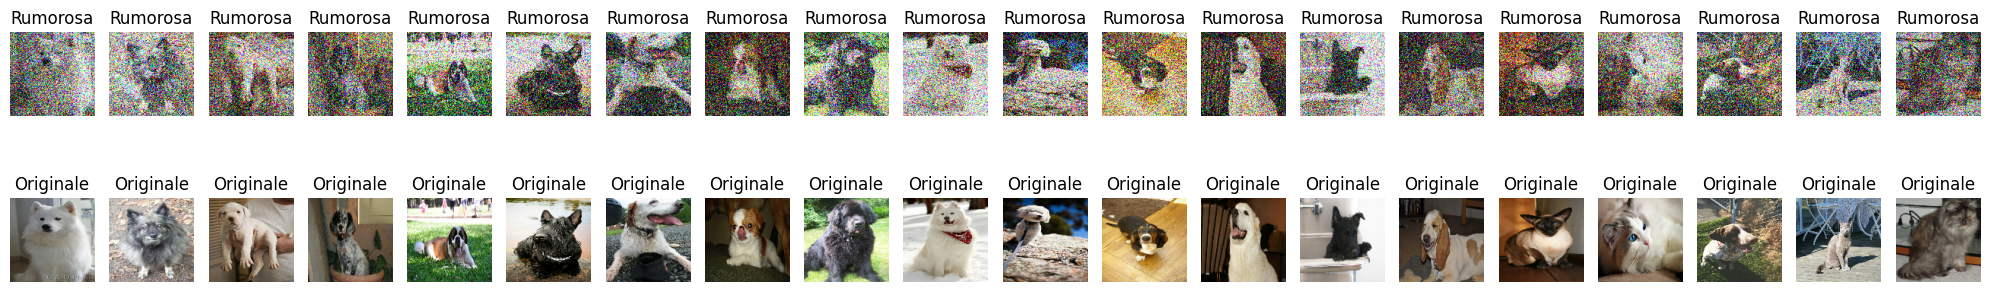

In [28]:
# Prendi un batch dal dataset (ad esempio, il primo batch)
batch = next(iter(test_ds_noisy))

x_noisy_batch, x_original_batch = batch

# Converti i tensori in array NumPy
x_noisy_np = x_noisy_batch.numpy()
x_original_np = x_original_batch.numpy()

# Usa la funzione plot_side_by_side per visualizzare n immagini
plot_side_by_side(x_noisy_np, x_original_np, n=batch_size)


In [37]:
def psnr_batch(originals, denoiseds, max_pixel = 1.0):
  """
  Calcola il PSNR per ogni coppia di immagini in due batch.

  originals: np.array di shape (N, H, W, C)
  denoised: np.array di shape (N, H, W, C)
  max_pixel: valore massimo del pixel (1.0 se normalizzato, 255 per uint8)
  Ritorna:
  - lista dei PSNR (uno per immagine)
  """
  assert originals.shape == denoiseds.shape, "Shape mismatch!"
  psnrs = []
  for i in range(originals.shape[0]):
      mse = np.mean((originals[i] - denoiseds[i]) ** 2)
      if mse == 0:
          psnrs.append(float('inf'))
      else:
          psnrs.append(10 * np.log10((max_pixel ** 2) / mse))

  return psnrs



def plot_psnr(psnr_set1, psnr_set2, psnr_set3 = [], title="PSNR per immagine"):
    """
    psnr_set1: lista o lista di liste con PSNR dei denoised (es. per livello di rumore)
    psnr_set2: idem per le immagini noisy
    """
    noise_levels = [i for i in range(5, 5 * (len(psnr_set1) + 1), 5)]

    # Assicura che ogni set sia lista di liste (es. una lista per livello)
    psnr_set1 = [np.atleast_1d(p) for p in psnr_set1]
    psnr_set2 = [np.atleast_1d(p) for p in psnr_set2]
    if(len(psnr_set3) > 0):
        psnr_set3 = [np.atleast_1d(p) for p in psnr_set3]

    # Figura
    plt.figure(figsize=(10, 6) )

    # Scatter di tutti i valori
    for i, level in enumerate(noise_levels):
        plt.scatter([level]*len(psnr_set1[i]), psnr_set1[i], marker='^', s=50, c='green', alpha=0.6)
        plt.scatter([level]*len(psnr_set2[i]), psnr_set2[i], marker='o', s=50, c='red', alpha=0.4)
        if(len(psnr_set3) > 0):
          plt.scatter([level]*len(psnr_set3[i]), psnr_set3[i], marker='x', s=50, c='blue', alpha=0.4)

    # Media PSNR per livello
    avg_psnr1 = [np.mean(p) for p in psnr_set1]
    avg_psnr2 = [np.mean(p) for p in psnr_set2]
    if(len(psnr_set3) > 0):
        avg_psnr3 = [np.mean(p) for p in psnr_set3]

    # Linea media
    plt.plot(noise_levels, avg_psnr1, color='green', label='Media PSNR - Denoised', linewidth=2)
    plt.plot(noise_levels, avg_psnr2, color='red', label='Media PSNR - Noisy', linewidth=2)
    if(len(psnr_set3) > 0):
        plt.plot(noise_levels, avg_psnr3, color='blue', label='Media PSNR - Noisy +', linewidth=2)

    plt.xlabel('Noise Level')
    plt.ylabel('PSNR (dB)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [30]:
model = RIDNET(n_feats=32, rgb_range=1.0)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_shift_2        │ (None, None,      │          0 │ input_layer_1[0]… │
│ (MeanShift)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, None,      │        896 │ mean_shift_2[0][… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_4 (Block)     │ (None, None,      │     93,666 │ conv2d_50[0][0]   │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_5 (Block)     │ (None, None,      │     93,666 │ block_4[0][0]     │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_6 (Block)     │ (None, None,      │     93,666 │ block_5[0][0]     │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_7 (Block)     │ (None, None,      │     93,666 │ block_6[0][0]     │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, None,      │        867 │ block_7[0][0]     │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_shift_3        │ (None, None,      │          0 │ conv2d_99[0][0]   │
│ (MeanShift)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_97 (Add)        │ (None, None,      │          0 │ mean_shift_3[0][… │
│                     │ None, 3)          │            │ input_layer_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 376,427 (1.44 MB)

 Trainable params: 376,427 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.fit(train_ds_noisy,
          epochs=50,
          batch_size=64,
          shuffle=True,
          validation_data=test_ds_noisy)

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 90s 345ms/step - loss: 0.1477 - val_loss: 0.0188
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 64s 338ms/step - loss: 0.0156 - val_loss: 0.0115
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 64s 336ms/step - loss: 0.0106 - val_loss: 0.0109
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 70s 368ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 64s 338ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 65s 336ms/step - loss: 0.0084 - val_loss: 0.0081
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 64s 336ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 8/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 64s 337ms/step - loss: 0.0073 - val_loss: 0.0075
Epoch 9/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 70s 369ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 10/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 64s 338ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 11/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 65s 336ms/step - loss: 0.0067 - val_loss: 0.0071
Epoch 12/50
184/184

In [32]:
decoded_imgs = model.predict(x_noisy_np)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


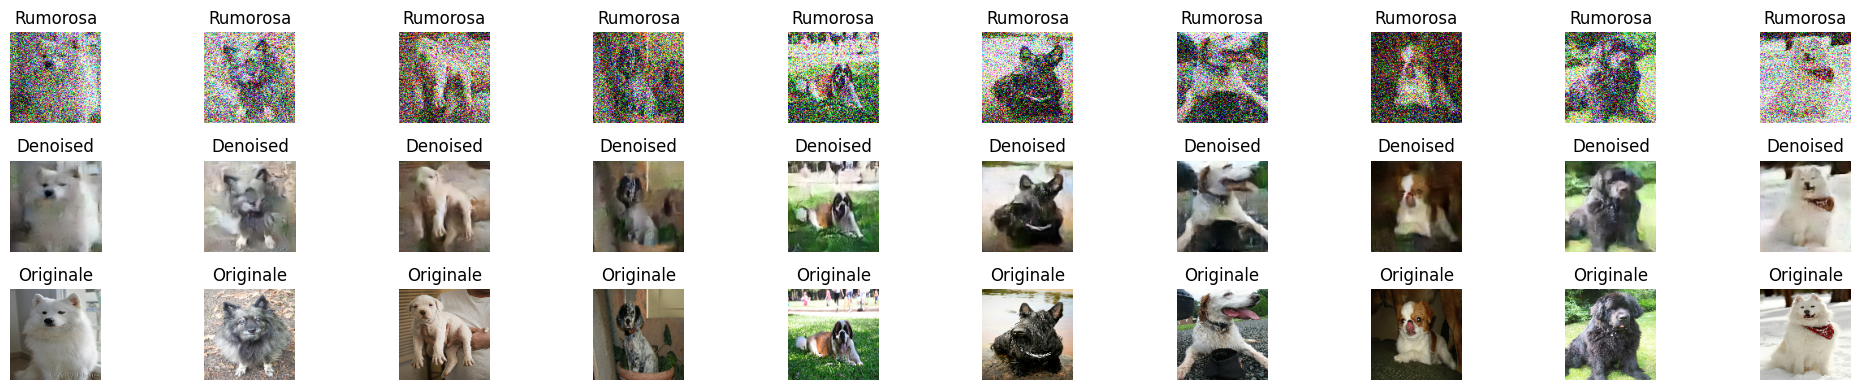

In [33]:
plot_denoising_results(x_noisy_np, decoded_imgs, x_original_np, n=10)

20
20


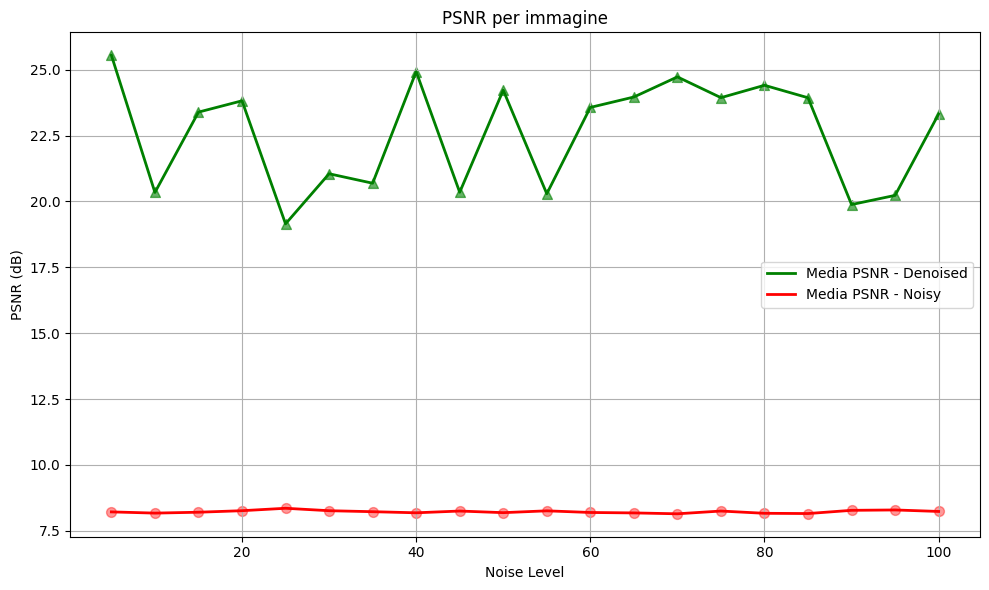

In [ ]:
#x_noisy_np, decoded_imgs, x_original_np

set1 = psnr_batch(x_original_np, decoded_imgs)
set2 = psnr_batch(x_noisy_np, decoded_imgs)
print(set1.__len__())
print(set2.__len__())

plot_psnr( set1, set2)

In [35]:
model.save('new_RIDNET.keras')